<a href="https://colab.research.google.com/github/2021aim1014/Master-Thesis-Project/blob/main/Our_results_on_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Results on CIFAR-10 dataset using our approach

In [ ]:
!pip install pyro-ppl
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
from torch.nn.functional import softmax
from torch import nn, optim
from tqdm.auto import tqdm
import torch
import pandas as pd

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model

In [ ]:
def temperature_scaling(logits, y):
    temperature = 1.0
    n_classes = logits.shape[1]
    _model_logits = torch.from_numpy(logits)
    _y = torch.from_numpy(y)
    _temperature = torch.tensor(temperature, requires_grad=True)

    # Optimization parameters
    nll = nn.CrossEntropyLoss()  # Supervised hard-label loss
    num_steps = 7500
    learning_rate = 0.05
    grad_tol = 1e-3  # Gradient tolerance for early stopping
    min_temp, max_temp = 1e-2, 1e4  # Upper / lower bounds on temperature

    optimizer = optim.Adam([_temperature], lr=learning_rate)

    loss_trace = []  # Track loss over iterations
    step = 0
    converged = False
    while not converged:
        # if(num_steps % 100 == 0): print(_temperature)
        optimizer.zero_grad()
        loss = nll(_model_logits / _temperature, _y)
        loss.backward()
        optimizer.step()
        loss_trace.append(loss.item())

        with torch.no_grad():
            _temperature.clamp_(min=min_temp, max=max_temp)

        step += 1
        # if step > num_steps:
        #     warnings.warn('Maximum number of steps reached -- may not have converged (TS)')
        converged = (step > num_steps) or (np.abs(_temperature.grad) < grad_tol)

    loss_trace = loss_trace
    temperature = _temperature.item()
    return temperature

In [ ]:
def display_results(y_pred, Y_pred, y_test):
    result = {
    'Missclassification Cost':[],
    'Human Cost':[],
    'Combined': [],
    'Human correct': [],
    'Human refered': [],
    'Human accuracy': [],
    'Model correct': [],
    'Model refered': [],
    'Model accuracy': [],
    'Loss': []
    }

    for human_cost in range(10):
        for miss_cost in range(human_cost+1, 10):
            correct = 0
            total = y_test.shape[0]
            combined_accuracy = 0
            human_correct = 0
            human_refered = 0
            human_accuracy = 0
            model_correct = 0
            model_refered = 0
            model_accuracy = 0
            loss = 0
            for i in range(total):
                P_X = miss_cost * (1 - y_pred[i][Y_pred[i]])
                if(human_cost <= P_X):
                    human_refered += 1
                    # if(y_test[i] == human_test_labels[i]):
                    human_correct += 1
                    correct += 1
                else:
                    model_refered += 1
                    if(Y_pred[i] == y_test[i]):
                        model_correct += 1
                        correct += 1

            combined_accuracy = 100 * correct / total
            human_accuracy = 100 * human_correct / (human_refered + 0.000001)
            model_accuracy = 100 * model_correct / (model_refered + 0.000001)
            loss = miss_cost * (model_refered - model_correct) + human_cost * human_refered

            result['Missclassification Cost'].append(miss_cost)
            result['Human Cost'].append(human_cost)
            result['Combined'].append(combined_accuracy)
            result['Human correct'].append(human_correct)
            result['Human refered'].append(human_refered)
            result['Human accuracy'].append(human_accuracy)
            result['Model correct'].append(model_correct)
            result['Model refered'].append(model_refered)
            result['Model accuracy'].append(model_accuracy)
            result['Loss'].append(loss)

    return result

In [ ]:
def combine_human_model(y_pred, Y_pred, y_test, human_cost, miss_cost):
    combined_y_pred = []
    total = y_test.shape[0]
    for i in range(total):
        P_X = miss_cost * (1 - y_pred[i][Y_pred[i]])
        if(human_cost <= P_X):
            combined_y_pred.append(y_test[i])   # Expert has 100% accuracy
        else:
            combined_y_pred.append(Y_pred[i])

    return combined_y_pred

In [ ]:
def model_fun(x_train, y_train):
    # number of classes
    K = len(set(y_train))

    # calculate total number of classes
    # for output layer
    print("number of classes:", K)

    # Build the model using the functional API
    # input layer
    i = Input(shape=x_train[0].shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dropout(0.2)(x)

    # Hidden layer
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.2)(x)

    # last hidden layer i.e.. output layer
    x = Dense(K, activation='softmax')(x)

    model = Model(i, x)

    # model description
    # model.summary()
    return model

In [ ]:
def print_classwise_accuracy(y_val, Y_pred):
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    for label, prediction in zip(y_val, Y_pred):
        if label == prediction:
            correct_pred[classes[label]] += 1
        total_pred[classes[label]] += 1


    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

In [ ]:
# Load in the data
cifar10 = tf.keras.datasets.cifar10

# Distribute it to train and test set
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

170498071/170498071 [==============================] - 13s 0us/step


In [ ]:
import sklearn.model_selection as sk

x_train, x_val, y_train, y_val = sk.train_test_split(x_train, y_train, test_size=0.3, random_state = 42)
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(35000, 32, 32, 3) (35000, 1) (15000, 32, 32, 3) (15000, 1)


In [ ]:
# Reduce pixel values
x_train, x_val, x_test = x_train / 255.0, x_val / 255.0, x_test / 255.0

# flatten the label values
y_train, y_val, y_test = y_train.flatten(), y_val.flatten(), y_test.flatten()


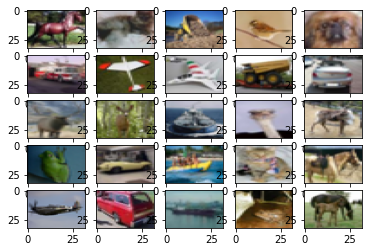

In [ ]:
# visualize data by plotting images
fig, ax = plt.subplots(5, 5)
k = 0

for i in range(5):
	for j in range(5):
		ax[i][j].imshow(x_train[k], aspect='auto')
		k += 1

plt.show()


In [ ]:
model = model_fun(x_train, y_train)
# Compile
model.compile(optimizer='adam',
			loss='sparse_categorical_crossentropy',
			metrics=['accuracy'])


number of classes: 10


In [ ]:
batch_size = 32
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

train_generator = data_generator.flow(x_train, y_train, batch_size)
steps_per_epoch = x_train.shape[0] // batch_size

r = model.fit(train_generator, validation_data=(x_val, y_val), steps_per_epoch=steps_per_epoch, epochs=2)


Epoch 1/2
1093/1093 [==============================] - 23s 21ms/step - loss: 0.7526 - accuracy: 0.7397 - val_loss: 0.7766 - val_accuracy: 0.7404
Epoch 2/2
1093/1093 [==============================] - 23s 21ms/step - loss: 0.7051 - accuracy: 0.7589 - val_loss: 0.7223 - val_accuracy: 0.7558


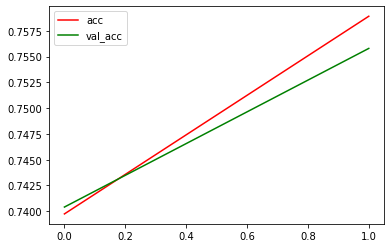

In [ ]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc', color='red')
plt.plot(r.history['val_accuracy'], label='val_acc', color='green')
plt.legend()

### Validation

In [ ]:
# Test Accuracy on validation Dataset
y_pred = model.predict(x_val)
Y_pred = np.argmax(y_pred, axis=1)
np.mean(Y_pred == y_val)

469/469 [==============================] - 1s 3ms/step


0.7558

In [ ]:
# Print classwise accuray of validation dataset
print_classwise_accuracy(y_val, Y_pred)

Accuracy for class: plane is 82.6 %
Accuracy for class: car   is 91.1 %
Accuracy for class: bird  is 62.7 %
Accuracy for class: cat   is 40.5 %
Accuracy for class: deer  is 81.6 %
Accuracy for class: dog   is 58.4 %
Accuracy for class: frog  is 92.0 %
Accuracy for class: horse is 80.1 %
Accuracy for class: ship  is 80.7 %
Accuracy for class: truck is 88.3 %


In [ ]:
# Display our approach results varing missclassification cost and human cost
result = display_results(y_pred, Y_pred, y_val)
pd.DataFrame.from_dict(result)[9:23]

,Missclassification Cost,Human Cost,Combined,Human correct,Human refered,Human accuracy,Model correct,Model refered,Model accuracy,Loss
9,2,1,86.706667,2700,2700,100.0,10306,12300,83.788618,6688
10,3,1,92.566667,4596,4596,100.0,9289,10404,89.282968,7941
11,4,1,94.713333,5521,5521,100.0,8686,9479,91.634139,8693
12,5,1,95.846667,6108,6108,100.0,8269,8892,92.993702,9223
13,6,1,96.593333,6544,6544,100.0,7945,8456,93.956954,9610
14,7,1,97.073333,6854,6854,100.0,7707,8146,94.610852,9927
15,8,1,97.373333,7098,7098,100.0,7508,7902,95.013921,10250
16,9,1,97.626667,7300,7300,100.0,7344,7700,95.376623,10504
17,3,2,79.373333,806,806,100.0,11100,14194,78.202057,10894
18,4,2,86.706667,2700,2700,100.0,10306,12300,83.788618,13376


In [ ]:
# Calculate the predictions after combining expert and model predictions using human cost and missclassification cost from best result of above cell
Y_combined = combine_human_model(y_pred, Y_pred, y_val, 1, 4)
# Print the classwise accuracy on combined predictions
print_classwise_accuracy(y_val, Y_combined)

Accuracy for class: plane is 96.1 %
Accuracy for class: car   is 96.3 %
Accuracy for class: bird  is 90.3 %
Accuracy for class: cat   is 89.0 %
Accuracy for class: deer  is 96.0 %
Accuracy for class: dog   is 93.2 %
Accuracy for class: frog  is 99.0 %
Accuracy for class: horse is 97.0 %
Accuracy for class: ship  is 94.2 %
Accuracy for class: truck is 96.4 %


In [ ]:
# TEMPERATURE SCALING  FOR CALIBRATING MODEL PREDICTIONS
clipped_model_probs = np.clip(y_pred, 1e-40, 1)
model_logits = np.log(clipped_model_probs)

temperature = temperature_scaling(model_logits, y_val)

calibrated_probs = y_pred ** (1. / temperature)  # Temper
calibrated_probs /= np.sum(calibrated_probs, axis=1, keepdims=True)  # Normalize

In [ ]:
# Display our approach results varing missclassification cost and human cost ON CALIBRATED 
result = display_results(calibrated_probs, Y_pred, y_val)
pd.DataFrame.from_dict(result)[9:23]

,Missclassification Cost,Human Cost,Combined,Human correct,Human refered,Human accuracy,Model correct,Model refered,Model accuracy,Loss
9,2,1,88.800000,3319,3319,100.0,10001,11681,85.617670,6679
10,3,1,94.326667,5332,5332,100.0,8817,9668,91.197766,7885
11,4,1,96.233333,6320,6320,100.0,8115,8680,93.490783,8580
12,5,1,97.146667,6899,6899,100.0,7673,8101,94.716702,9039
13,6,1,97.640000,7296,7296,100.0,7350,7704,95.404984,9420
14,7,1,98.000000,7613,7613,100.0,7087,7387,95.938811,9713
15,8,1,98.313333,7898,7898,100.0,6849,7102,96.437623,9922
16,9,1,98.526667,8128,8128,100.0,6651,6872,96.784051,10117
17,3,2,80.940000,1177,1177,100.0,10964,13823,79.317080,10931
18,4,2,88.800000,3319,3319,100.0,10001,11681,85.617670,13358


In [ ]:
# Calculate the predictions after combining expert and model predictions using human cost and missclassification cost from best result of above cell
Y_combined = combine_human_model(calibrated_probs, Y_pred, y_val, 1, 4)
print_classwise_accuracy(y_val, Y_combined)

Accuracy for class: plane is 97.7 %
Accuracy for class: car   is 96.8 %
Accuracy for class: bird  is 93.0 %
Accuracy for class: cat   is 91.4 %
Accuracy for class: deer  is 96.8 %
Accuracy for class: dog   is 95.9 %
Accuracy for class: frog  is 99.2 %
Accuracy for class: horse is 98.6 %
Accuracy for class: ship  is 95.9 %
Accuracy for class: truck is 97.4 %


In [ ]:
# Calculate T correcponding to each class
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# prepare to count predictions for each class
classwise_T = {classname: 0 for classname in classes}
classwise_model_logits = {classname: [] for classname in classes}
classwise_true_label = {classname: [] for classname in classes}

for y_true_each, y_pred_each, logits in zip(y_val, Y_pred, model_logits):
    classwise_model_logits[classes[y_pred_each]].append(logits)
    classwise_true_label[classes[y_pred_each]].append(y_true_each)

for class_name in classes:
    logits = np.array(classwise_model_logits[class_name])
    y_true = np.array(classwise_true_label[class_name])
    classwise_T[class_name] = temperature_scaling(logits, y_true)

In [ ]:
classwise_T

{'plane': 1.213780164718628,
 'car': 1.2054158449172974,
 'bird': 0.996873140335083,
 'cat': 0.6720720529556274,
 'deer': 1.32864248752594,
 'dog': 0.6266573667526245,
 'frog': 1.7179476022720337,
 'horse': 0.9522812962532043,
 'ship': 0.8346484899520874,
 'truck': 1.2720764875411987}

In [ ]:
calibrated_probs = np.array([[0.0]*len(classes)] * Y_pred.shape[0])
for i in range(Y_pred.shape[0]):
    T = classwise_T[classes[Y_pred[i]]]
    calibrated_probs[i] = y_pred[i] ** (1. / T)
    calibrated_probs[i] /= np.sum(calibrated_probs[i])  # Normalize

In [ ]:
# Display our approach results varing missclassification cost and human cost ON CALIBRATED 
result = display_results(calibrated_probs, Y_pred, y_val)
pd.DataFrame.from_dict(result)[9:23]

,Missclassification Cost,Human Cost,Combined,Human correct,Human refered,Human accuracy,Model correct,Model refered,Model accuracy,Loss
9,2,1,88.933333,3016,3016,100.0,10324,11984,86.148198,6336
10,3,1,94.720000,5000,5000,100.0,9208,10000,92.080000,7376
11,4,1,96.480000,5953,5953,100.0,8519,9047,94.163811,8065
12,5,1,97.360000,6554,6554,100.0,8050,8446,95.311390,8534
13,6,1,97.933333,7027,7027,100.0,7663,7973,96.111878,8887
14,7,1,98.260000,7377,7377,100.0,7362,7623,96.576151,9204
15,8,1,98.546667,7642,7642,100.0,7140,7358,97.037238,9386
16,9,1,98.746667,7871,7871,100.0,6941,7129,97.362884,9563
17,3,2,81.220000,1067,1067,100.0,11116,13933,79.781813,10585
18,4,2,88.933333,3016,3016,100.0,10324,11984,86.148198,12672


In [ ]:
# Calculate the predictions after combining expert and model predictions using human cost and missclassification cost from best result of above cell
Y_combined = combine_human_model(calibrated_probs, Y_pred, y_val, 1, 4)
print_classwise_accuracy(y_val, Y_combined)

Accuracy for class: plane is 97.0 %
Accuracy for class: car   is 97.2 %
Accuracy for class: bird  is 94.9 %
Accuracy for class: cat   is 93.3 %
Accuracy for class: deer  is 97.1 %
Accuracy for class: dog   is 95.2 %
Accuracy for class: frog  is 98.4 %
Accuracy for class: horse is 97.9 %
Accuracy for class: ship  is 96.4 %
Accuracy for class: truck is 97.6 %


### Testing

In [ ]:
y_pred = model.predict(x_test)
Y_pred = np.argmax(y_pred, axis=1)
np.mean(Y_pred == y_test)

313/313 [==============================] - 1s 3ms/step


0.7568

In [ ]:
result = display_results(y_pred, Y_pred, y_test)

In [ ]:
import pandas as pd
pd.DataFrame.from_dict(result)[9:23]

,Missclassification Cost,Human Cost,Combined,Human correct,Human refered,Human accuracy,Model correct,Model refered,Model accuracy,Loss
9,2,1,86.54,1774,1774,100.0,6880,8226,83.637248,4466
10,3,1,91.92,3012,3012,100.0,6180,6988,88.437321,5436
11,4,1,93.98,3616,3616,100.0,5782,6384,90.570175,6024
12,5,1,95.15,3973,3973,100.0,5542,6027,91.952879,6398
13,6,1,95.75,4237,4237,100.0,5338,5763,92.625369,6787
14,7,1,96.25,4460,4460,100.0,5165,5540,93.231047,7085
15,8,1,96.63,4663,4663,100.0,5000,5337,93.685591,7359
16,9,1,96.97,4818,4818,100.0,4879,5182,94.152837,7545
17,3,2,79.48,539,539,100.0,7409,9461,78.310961,7234
18,4,2,86.54,1774,1774,100.0,6880,8226,83.637248,8932


In [ ]:
calibrated_probs = y_pred ** (1. / temperature)  # Temper
calibrated_probs /= np.sum(calibrated_probs, axis=1, keepdims=True)  # Normalize

In [ ]:
result = display_results(calibrated_probs, Y_pred, y_test)

In [ ]:
import pandas as pd
pd.DataFrame.from_dict(result)[9:23]

,Missclassification Cost,Human Cost,Combined,Human correct,Human refered,Human accuracy,Model correct,Model refered,Model accuracy,Loss
9,2,1,88.34,2162,2162,100.0,6672,7838,85.123756,4494
10,3,1,93.60,3477,3477,100.0,5883,6523,90.188564,5397
11,4,1,95.34,4094,4094,100.0,5440,5906,92.109719,5958
12,5,1,96.30,4493,4493,100.0,5137,5507,93.281278,6343
13,6,1,96.97,4822,4822,100.0,4875,5178,94.148320,6640
14,7,1,97.47,5040,5040,100.0,4707,4960,94.899194,6811
15,8,1,97.77,5237,5237,100.0,4540,4763,95.318077,7021
16,9,1,98.13,5380,5380,100.0,4433,4620,95.952381,7063
17,3,2,80.88,768,768,100.0,7320,9232,79.289428,7272
18,4,2,88.34,2162,2162,100.0,6672,7838,85.123756,8988


In [ ]:
# Y_pred[0]
# T = classwise_T[classes[Y_pred[0]]]
# temp = y_pred[0] ** (1. / T)
# y_pred[0] /= np.sum(y_pred[0])  # Normalize

In [ ]:
for i in range(Y_pred.shape[0]):
    # Y_pred[0]
    T = classwise_T[classes[Y_pred[i]]]
    y_pred[i] = y_pred[i] ** (1. / T)
    y_pred[i] /= np.sum(y_pred[i])  # Normalize

In [ ]:
result = display_results(y_pred, Y_pred, y_test)

In [ ]:
pd.DataFrame.from_dict(result)[9:23]

,Missclassification Cost,Human Cost,Combined,Human correct,Human refered,Human accuracy,Model correct,Model refered,Model accuracy,Loss
9,2,1,88.75,1988,1988,100.0,6887,8012,85.958562,4238
10,3,1,94.14,3321,3321,100.0,6093,6679,91.226231,5079
11,4,1,95.87,3932,3932,100.0,5655,6068,93.193804,5584
12,5,1,96.76,4342,4342,100.0,5334,5658,94.273595,5962
13,6,1,97.38,4640,4640,100.0,5098,5360,95.111940,6212
14,7,1,97.80,4887,4887,100.0,4893,5113,95.697242,6427
15,8,1,98.07,5071,5071,100.0,4736,4929,96.084398,6615
16,9,1,98.26,5235,5235,100.0,4591,4765,96.348374,6801
17,3,2,81.05,675,675,100.0,7430,9325,79.678284,7035
18,4,2,88.75,1988,1988,100.0,6887,8012,85.958562,8476
